## Laboratorium 14


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od zlokalizowania jakichś obiektów, być może z góry wiemy, gdzie obiekty się znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie nie będzie jednak centralne na laboratorium.

---

In [1]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from tqdm import tqdm

### Zadanie 1 (1.5 pkt | 1.0 pkt)

#### Zadanie 1a (1.5 pkt | 0.0 pkt)

Dany jest plik `amsterdam47.mp4` przedstawiający zapis ruchu na skrzyżowaniu. Uzupełnij podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii obiektów, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie znalezionych obiektów). Niekoniecznie musisz przetwarzać cały materiał wideo - zwróć uwagę, że pojazdy znikają poza klatką, uniemożliwiając ich dalsze śledzenie.

In [2]:
def get_all_frames(source: cv2.VideoCapture, color=False):
    frames = []
    frame1 = None
    status, frame2 = source.read()
    # inicjalizacja
    while status:
        frame1 = frame2
        status, frame2 = source.read()
        if not color:
            frames.append(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY))
        else:
            frames.append(frame1)
        # przetwarzanie
    return frames

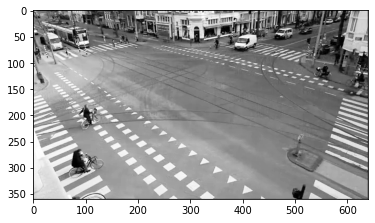

In [3]:
vid = cv2.VideoCapture('amsterdam47.mp4')
frames = get_all_frames(vid)
plt.imshow(frames[0], cmap='Greys_r')

In [4]:
def show_movement(filename='amsterdam47.mp4', start=0, end=None):
    frames = get_all_frames(cv2.VideoCapture(filename))[start:end]
    prev_frame = frames[0]
    
    prev_points = cv2.goodFeaturesToTrack(
            prev_frame,
            maxCorners=150,
            qualityLevel=0.01,
            minDistance=10,
        )

    if end:
        img = get_all_frames(cv2.VideoCapture(filename), color=True)[end]
    else:
        img = get_all_frames(cv2.VideoCapture(filename), color=True)[-1]
    lines = np.zeros_like(img)
    cmap = get_cmap('prism', prev_points.shape[0])

    for frame in tqdm(frames[1:]):
        next_points, _, _ = cv2.calcOpticalFlowPyrLK(
            prev_frame,
            frame,
            prev_points,
            None,
        )

        for i, (p1, p2) in enumerate(zip(prev_points.astype(int), next_points.astype(int))):
            c = cmap(i, bytes=True)[:3]
            c = tuple(map(int, c)) # this is retarded, thanks opencv
            lines = cv2.line(lines, p1.squeeze(), p2.squeeze(), c)

        prev_points = next_points
        prev_frame = frame

    _, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(cv2.add(lines, img))
    return plt.show()

100%|██████████| 362/362 [00:00<00:00, 460.56it/s]


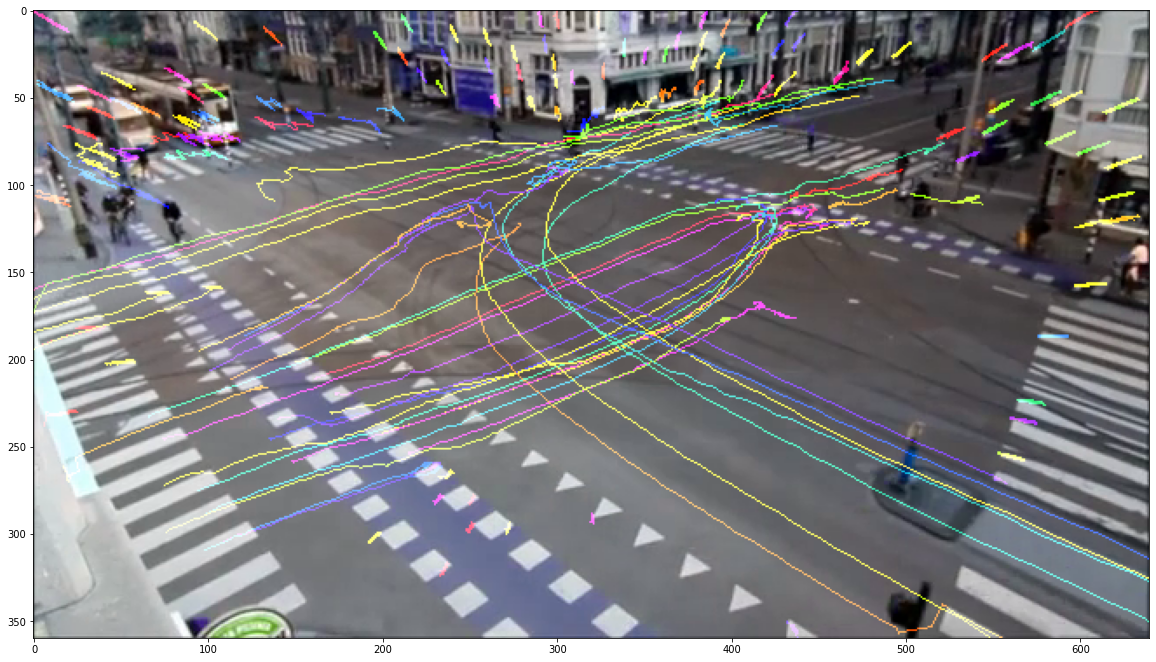

In [5]:
show_movement()

#### Zadanie 1b (0.0 pkt | 1.0 pkt)

Powtórz poprzednie doświadczenie na różnych fragmentach materiału źródłowego. Kiedy i w jaki sposób metoda zawodzi?

100%|██████████| 49/49 [00:00<00:00, 357.66it/s]


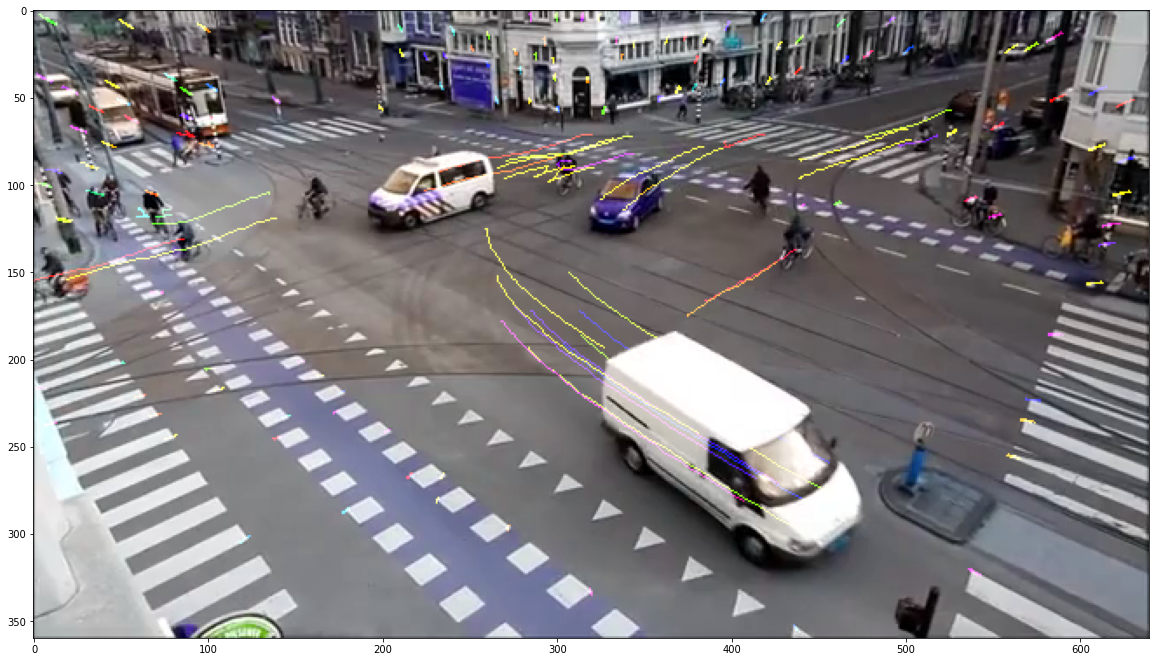

In [6]:
show_movement(start=200, end=250)

Komentarz 1:

Głównym problemem tej prostej implementacji jest to, że punkty zainteresowania są ustalane na podstawie pierwszej klatki i nie są aktualizowane nigdzie później. Na powyższym przykładzie widać 2 rowerzystów nieoznaczonych przez metodę. Oprócz tego jeden z samochodów został w pewnym momencie na chwilę zasłonięty częściowo przez innego rowerzystę. W tym momencie urywa się śledzenie niektórych punktów na tym samochodzie. Więc nie tylko nie są wykrywane nowe punkty zainteresowania, ale też jeżeli istniejące zostaną zgubione w którymkolwiek momencie, to nie da się ich przywrócić, nawet jeżeli znowu staną się widocznie na obrazie.

### Zadanie 2 (1.0 pkt | 0.0 pkt)

Wykorzystując historię położenia poszczególnych obiektów, zidentyfikuj punkty należące do tła i odfiltruj je ze zbioru śledzonych obiektów.  
*Jeśli starczy czasu:* zidentyfikuj punkty należące do tych samych obiektów (tj. poruszające się w ten sam sposób).

In [7]:
def show_movement2(filename='amsterdam47.mp4', start=0, end=None, threshold=200):
    frames = get_all_frames(cv2.VideoCapture(filename))[start:end]
    prev_frame = frames[0]
    
    points = [cv2.goodFeaturesToTrack(
            prev_frame,
            maxCorners=150,
            qualityLevel=0.01,
            minDistance=10,
        )]
    
    dists = np.zeros(points[0].shape[:-1])
    for frame in tqdm(frames[1:]):
        points.append(cv2.calcOpticalFlowPyrLK(
            prev_frame,
            frame,
            points[-1],
            None,
        )[0])
        dists += np.linalg.norm(points[-2] - points[-1], axis=2)
        prev_frame = frame
    
    mask = dists > threshold
    cmap = get_cmap('prism', points[0][mask].shape[0])
    
    if end:
        img = get_all_frames(cv2.VideoCapture(filename), color=True)[end]
    else:
        img = get_all_frames(cv2.VideoCapture(filename), color=True)[-1]
    lines = np.zeros_like(img)
    
    for i in range(len(points) - 1):
        for i, (p1, p2) in enumerate(zip(points[i][mask].squeeze().astype(int), points[i+1][mask].squeeze().astype(int))):
            c = cmap(i, bytes=True)[:3]
            c = tuple(map(int, c)) # this is retarded, thanks opencv
            lines = cv2.line(lines, p1, p2, c)

    _, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(cv2.add(lines, img))
    return plt.show()

100%|██████████| 362/362 [00:00<00:00, 1231.29it/s]


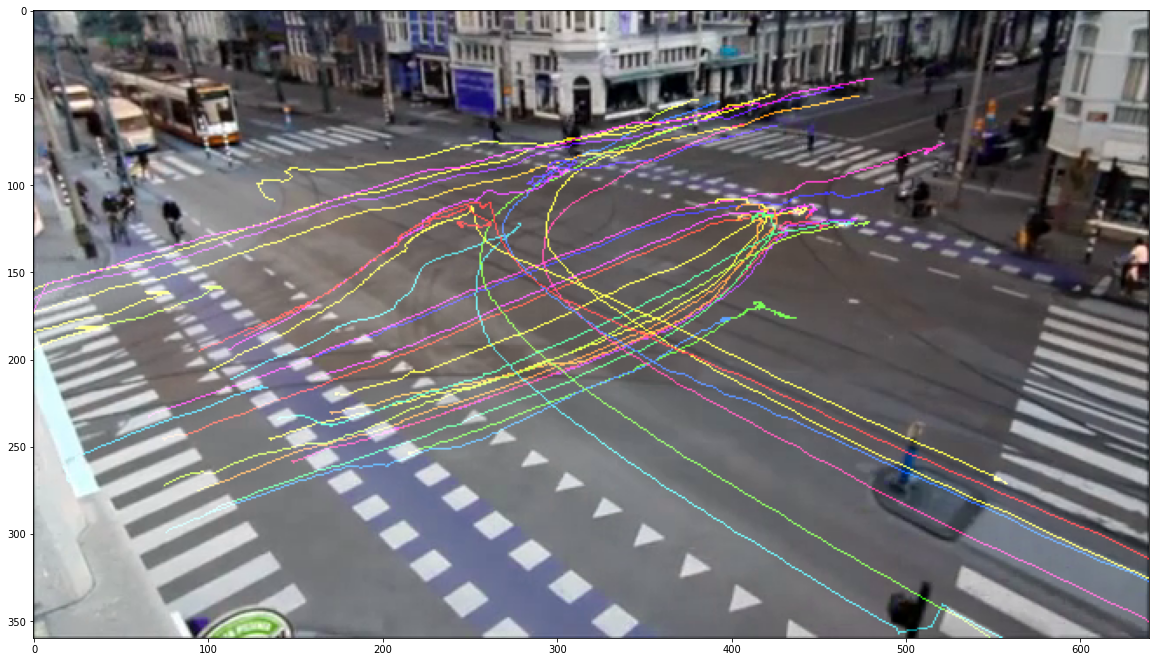

In [8]:
show_movement2()

#### Zadanie 3 (1.5 pkt | 0.0 pkt)

Rozszerz rozwiązanie z zadania 1 o możliwość śledzenia nowych obiektów pojawiających się w polu widzenia. Zadbaj o to, by ponowna detekcja punktów zainteresowania nie tworzyła duplikatów obiektów, które już są znane i śledzone.

In [9]:
def show_movement3(filename='amsterdam47.mp4', start=0, end=None):
    frames = get_all_frames(cv2.VideoCapture(filename))[start:end]
    prev_frame = frames[0]
    
    prev_points = cv2.goodFeaturesToTrack(
            prev_frame,
            maxCorners=150,
            qualityLevel=0.01,
            minDistance=10,
        )

    if end:
        img = get_all_frames(cv2.VideoCapture(filename), color=True)[end]
    else:
        img = get_all_frames(cv2.VideoCapture(filename), color=True)[-1]
    lines = np.zeros_like(img)

    for frame in tqdm(frames[1:]):
        next_points, _, _ = cv2.calcOpticalFlowPyrLK(
            prev_frame,
            frame,
            prev_points,
            None,
        )

        for i, (p1, p2) in enumerate(zip(prev_points.astype(int), next_points.astype(int))):
            lines = cv2.line(lines, p1.squeeze(), p2.squeeze(), (255, 0, 0))
        
        next_points = cv2.goodFeaturesToTrack(
            frame,
            maxCorners=150,
            qualityLevel=0.01,
            minDistance=10,
        )

        prev_points = next_points
        prev_frame = frame

    _, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(cv2.add(lines, img))
    return plt.show()

100%|██████████| 362/362 [00:01<00:00, 281.05it/s]


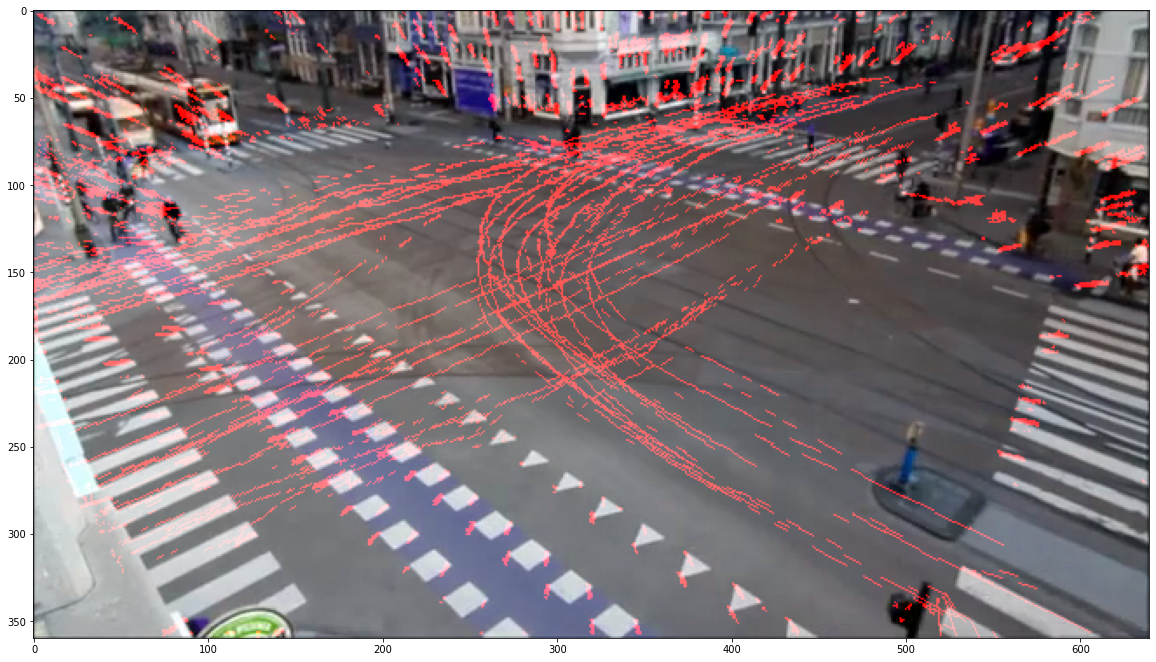

In [10]:
show_movement3()